# Human Activity Recognition 

### 결정트리

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
feature_name_df = pd.read_csv('.\\human_activity\\features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name_df

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [83]:
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [84]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1 ].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [85]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0]+'_'+
                                                                                              str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [86]:
import pandas as pd

def get_human_dataset():
    # 각 데이터 파일이 공백으로 분리되어 있어, read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                                 header=None, names=['column_index', 'column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 dataframe 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
   
    # dataframe에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습피처 데이터세트와 테스트 피처 데이터를 dataframe으로 로딩, 컬럼명은 feature_name으로 적용
    X_train = pd.read_csv('human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 dataframe으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 dataframe을 모두 반환
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = get_human_dataset()


In [87]:
print('## 학습 피처 데이터 셋 info()')
print(X_train.info())

## 학습 피처 데이터 셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [88]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [89]:
# 예측청확도 확인
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print("결정 트리 예측 정확도 : {0:.4f}".format(accuracy))

print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도 : 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [90]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8513
GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 16}


In [91]:
# max_depth값에 따른 예측 성능의 변화
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [92]:
# 별도의 테스트 데이터 세트로 정확도 측정
max_depths = [6, 8, 10, 12, 16, 20, 24]

for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0}, 정확도 : {1}'.format(depth, accuracy))

max_depth = 6, 정확도 : 0.8557855446216491
max_depth = 8, 정확도 : 0.8707159823549372
max_depth = 10, 정확도 : 0.8673227010519172
max_depth = 12, 정확도 : 0.8646080760095012
max_depth = 16, 정확도 : 0.8574821852731591
max_depth = 20, 정확도 : 0.8547675602307431
max_depth = 24, 정확도 : 0.8547675602307431


In [93]:
# GridSearchCV로 평가
params = {
    'max_depth' : [8, 12, 16, 20],
    'min_samples_split' : [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8549
GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 8, 'min_samples_split': 16}


In [94]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy - accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도{0:.4f}'.format(accuracy))

결정 트리 예측 정확도0.8548


<function matplotlib.pyplot.show(close=None, block=None)>

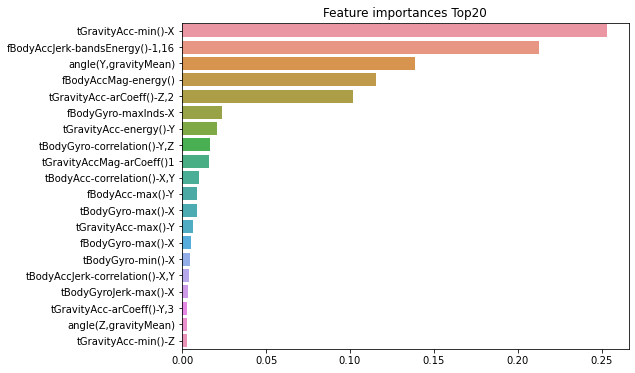

In [95]:
# 결정트리에서 각 피처의 중요도 그래프
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show

### 보팅 분류기

In [118]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

- 하드 보팅

In [119]:
lrc = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier()

In [120]:
voc = VotingClassifier(
    estimators=[('LRC',lrc),('SVC',svc),('KNN',knn)], voting='hard'
)
X_train, X_test, y_train, y_test = get_human_dataset()


In [121]:
voc.fit(X_train, y_train)
voc.score(X_test, y_test)

0.9545300305395318

In [122]:
lrc.fit(X_train, y_train)
svc.fit(X_train, y_train)
knn.fit(X_train, y_train)
lrc.score(X_test, y_test), svc.score(X_test, y_test), knn.score(X_test, y_test)

(0.9579233118425518, 0.9504580929759077, 0.9015948422124194)

- 소프트 보팅

In [135]:
lrc2 = LogisticRegression()
svc2 = SVC(probability=True)
knn2 = KNeighborsClassifier()

In [137]:
voc2 = VotingClassifier(
    estimators=[('LRC',lrc),('SVC',svc),('KNN',knn)], voting='soft'
)
X_train, X_test, y_train, y_test = get_human_dataset()

voc2.fit(X_train, y_train)
pred = voc2.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측 평가
classifiers = [lrc, svc, knn]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9576
LogisticRegression 정확도: 0.9579
SVC 정확도: 0.9505
KNeighborsClassifier 정확도: 0.9016


### 랜덤 포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


### XGBoost

In [212]:
import xgboost as xgb
from xgboost import plot_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [213]:
df = pd.read_csv('.\\human_activity\\features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
df

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [214]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovo')
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, ', end='')
    print(f'F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [216]:
X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, X_test.shape)

(7352, 561) (2947, 561)


In [217]:
xgb = XGBClassifier()
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [218]:
prams = {'max_depth':3,
         'learning_rate':0.1,
         'objective':'binary:logistic',
         'eval_metric':'logloss',
         'n_estimators': 100
        }
num_rounds = 400   

In [219]:
xgb = XGBClassifier(max_depth=3, learning_rate=0.1, objective='binary:logistic', eval_metric='logloss', n_estimators=100)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [220]:
pred = xgb.predict(X_test)
pred_proba = xgb.predict_proba(X_test)

In [221]:
accuracy_score(y_test, pred)

0.9406175771971497